In [175]:
import pandas
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#distance
import gower

# x_reconstructed[self.binary_indices]
import importlib
import utils
importlib.reload(utils)

import models
importlib.reload(models)

import preprocessing
importlib.reload(preprocessing)
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchsummary

from torch.utils.data import Dataset, DataLoader
import sys

sns.set_palette('Set2')

In [176]:
df = preprocessing.load_dataset()
data_tensor = torch.tensor(df.to_numpy(), dtype=torch.float32)
binary_indices = utils.binary_indices
continuous_indices = utils.continuous_indices

In [177]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        # Assuming dataframe is already scaled and prepared for neural network input
        self.data = torch.tensor(dataframe.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Returns a sample from the dataset
        return self.data[idx]
def create_dataloader(df, batch_size=1, shuffle=True):
    dataset = DataFrameDataset(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader
dataloader = create_dataloader(df, batch_size=32, shuffle=True)

# here insert the right model

In [178]:
model = models.Autoencoder_Encoder(binary_indices = binary_indices)
torchsummary.summary(model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       352
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       136
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       27
├─Sequential: 1-2                        --
|    └─Linear: 2-6                       32
|    └─ReLU: 2-7                         --
|    └─Linear: 2-8                       144
|    └─ReLU: 2-9                         --
|    └─Linear: 2-10                      357
Total params: 1,048
Trainable params: 1,048
Non-trainable params: 0


In [179]:
epochs = 50
importlib.reload(utils)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
criterion = models.Autoencoder_Loss_Prob(binary_indices=binary_indices, 
                                         continuous_indices= continuous_indices)
    
for epoch in range(epochs):
    for data in dataloader:
        model.train()
        optimizer.zero_grad()
        x_reconstructed = model(data) 
        loss = criterion(data, x_reconstructed)
        #print(f"x rec = {x_reconstructed}\n, data = {data}")
        #loss = utils.gower_loss(data, x_reconstructed , binary_indices, continuous_indices)
        #print(loss)
        #sys.exit()
        loss.backward()
        optimizer.step()
        # Step the scheduler
    scheduler.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]}')
print("Training complete")

Epoch [1/50], Loss: 0.1409, LR: 0.01
Epoch [11/50], Loss: 0.0427, LR: 0.01
Epoch [21/50], Loss: 0.0062, LR: 0.01
Epoch [31/50], Loss: 0.0070, LR: 0.005
Epoch [41/50], Loss: 0.0026, LR: 0.005
Training complete


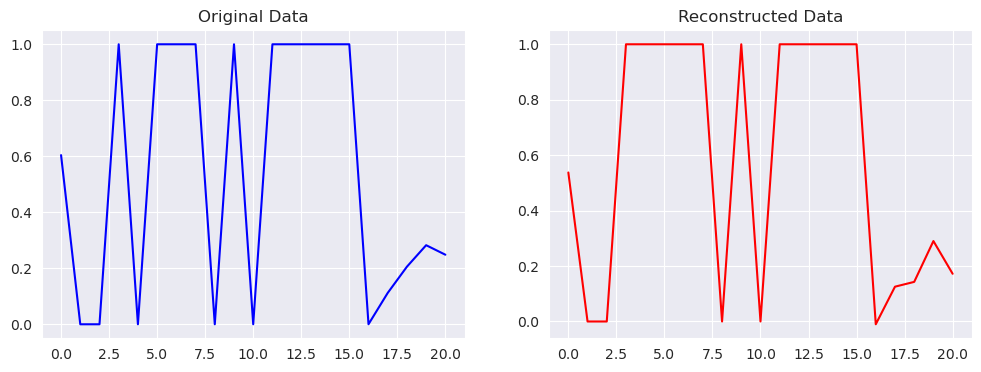

In [180]:
model.eval()
test_output = model(data_tensor)

index = 1
index = 1626
original_data = data_tensor.numpy()[index]
reconstructed_data = test_output.detach().numpy()[index]
reconstructed_data[binary_indices] = (reconstructed_data[binary_indices] > 0.5)
#reconstructed_data[binary_indices] = (reconstructed_data[binary_indices])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(original_data, 'b')
axes[0].set_title('Original Data')
axes[1].plot(reconstructed_data, 'r')
axes[1].set_title('Reconstructed Data')
plt.show()

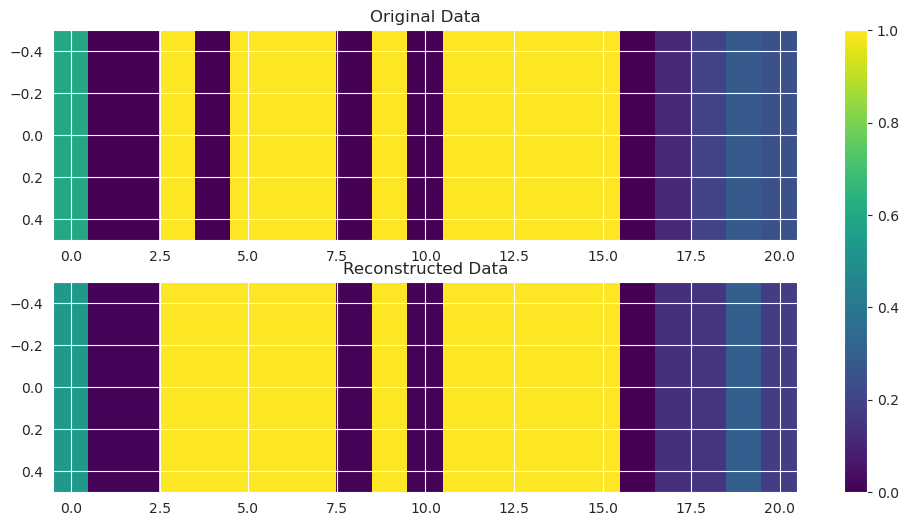

In [181]:
# Create the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

# Reshape the 1D arrays to 2D (1 x number of elements)
original_data_2d = original_data.reshape(1, -1)
reconstructed_data_2d = reconstructed_data.reshape(1, -1)

# Heatmap for original data
cax1 = axes[0].imshow(original_data_2d, cmap='viridis', aspect='auto')
axes[0].set_title('Original Data')
# fig.colorbar(cax1, ax=axes[0])

# Heatmap for reconstructed data
cax2 = axes[1].imshow(reconstructed_data_2d, cmap='viridis', aspect='auto')
axes[1].set_title('Reconstructed Data')
# fig.colorbar(cax2, ax=axes[[1]])
fig.colorbar(cax1, ax=axes, orientation='vertical')
# Display the plot
plt.show()

In [182]:
distances = [criterion( data_tensor[i,:].unsqueeze(0), 
                        model(data_tensor)[i,:].unsqueeze(0)).item() for i in range(len(df))]

<Axes: ylabel='Count'>

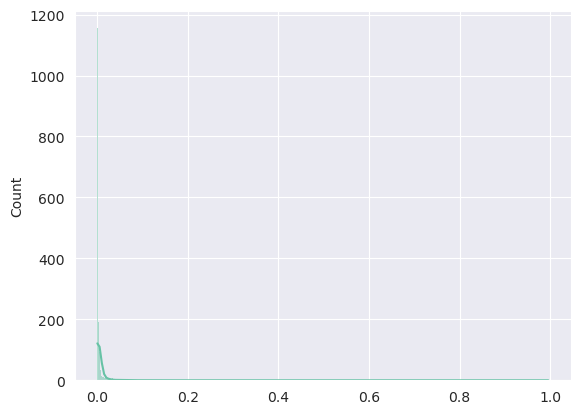

In [183]:
sns.histplot(distances, kde=True)

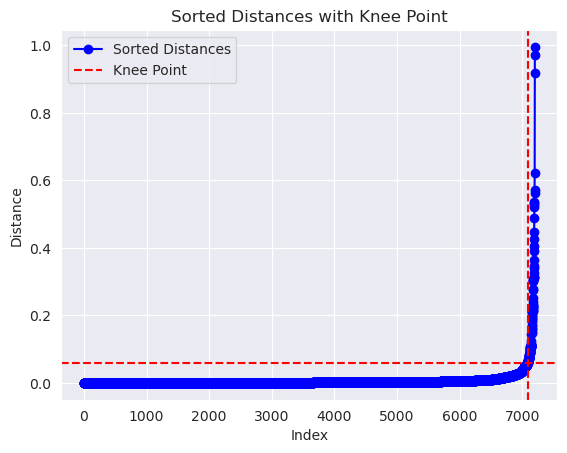

In [184]:
from kneed import KneeLocator

sorted_distances = np.sort(distances)

# Use KneeLocator to find the knee point
knee = KneeLocator(range(len(sorted_distances)), sorted_distances, curve='convex', direction='increasing')

# Plot the sorted distances
plt.plot(sorted_distances, marker='o', linestyle='-', color='b', label='Sorted Distances')

# Mark the knee point
plt.axvline(x=knee.knee, color='r', linestyle='--', label='Knee Point')
plt.axhline(y=sorted_distances[knee.knee], color='r', linestyle='--')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Sorted Distances with Knee Point')
plt.legend()

# Show the plot
plt.show()


In [185]:
treshold = knee.knee_y
print(f"treshold was set to: {treshold}")

treshold was set to: 0.06044607236981392


In [186]:
outlier_index = [-1 if i > treshold/2 else 0 for i in distances]
print(f"percentage of outliers was set to: {-np.sum(outlier_index)/len(outlier_index) * 100: .2f}%")

percentage of outliers was set to:  3.25%


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7200 samples in 0.036s...
[t-SNE] Computed neighbors for 7200 samples in 0.515s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7200
[t-SNE] Computed conditional probabilities for sample 2000 / 7200
[t-SNE] Computed conditional probabilities for sample 3000 / 7200
[t-SNE] Computed conditional probabilities for sample 4000 / 7200
[t-SNE] Computed conditional probabilities for sample 5000 / 7200
[t-SNE] Computed conditional probabilities for sample 6000 / 7200
[t-SNE] Computed conditional probabilities for sample 7000 / 7200
[t-SNE] Computed conditional probabilities for sample 7200 / 7200
[t-SNE] Mean sigma: 0.003135
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.343544
[t-SNE] KL divergence after 1000 iterations: 0.980971


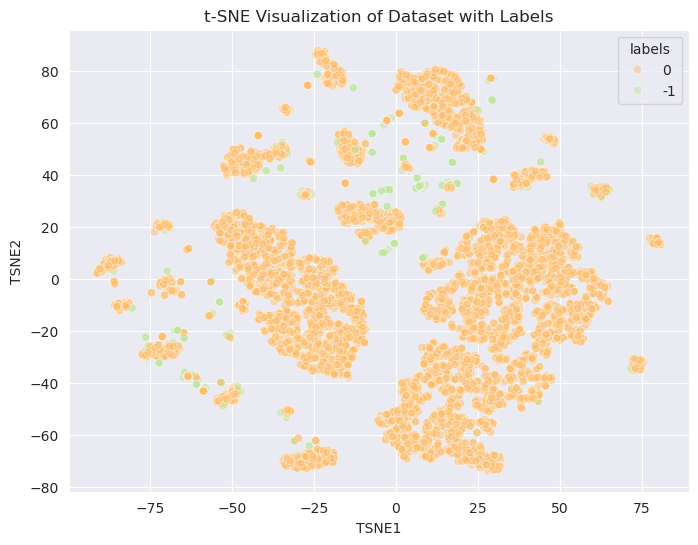

In [187]:
utils.plot_TSNE(df, outlier_index, dist_matrix=gower.gower_matrix(df))

In [188]:
pd.concat([
    np.abs(np.sum((df[np.array(outlier_index) == -1]).iloc[:,binary_indices]-1,axis = 1)).describe(),
    np.abs(np.sum((df[np.array(outlier_index) != -1]).iloc[:,binary_indices]-1,axis = 1)).describe()], 
    axis = 1,
    keys = ['falses/obs Outliers', 'Falses/obs non-out'])

,falses/obs Outliers,Falses/obs non-out
count,234.000000,6966.000000
mean,2.192308,0.725093
std,0.839850,0.712976
min,0.000000,0.000000
25%,2.000000,0.000000
50%,2.000000,1.000000
75%,3.000000,1.000000
max,5.000000,5.000000


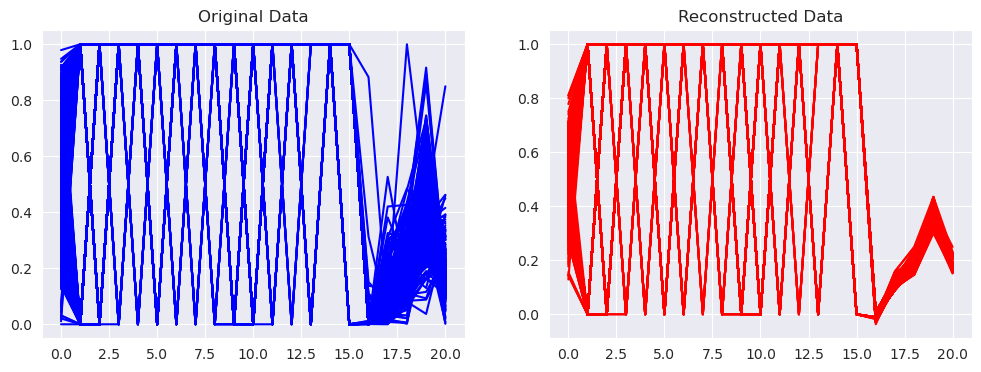

In [189]:
import random
model.eval()
test_output = model(data_tensor)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i in random.sample(range(0, len(df)), 1000):
    original_data = data_tensor.numpy()[i]
    reconstructed_data = test_output.detach().numpy()[i]
    reconstructed_data[binary_indices] = (reconstructed_data[binary_indices] > 0.5)
    #reconstructed_data[binary_indices] = (reconstructed_data[binary_indices])
    axes[0].plot(original_data, 'b')
    axes[0].set_title('Original Data')
    axes[1].plot(reconstructed_data, 'r')
    axes[1].set_title('Reconstructed Data')
plt.show()

# how we chose losses


In [190]:
binary_temp_ind = [0]
continuous_temp_ind = [1]

x = torch.tensor([1.0, 1.0]).unsqueeze(0)
y = torch.tensor([0.5, 0.5]).unsqueeze(0)

bce = nn.BCELoss()
l1 = nn.MSELoss()

binary_loss = bce(x[:, binary_temp_ind], y[:, binary_temp_ind])
continuous_loss = l1(x[:, continuous_temp_ind], y[:, continuous_temp_ind])

combined_loss = (binary_loss + continuous_loss) / 2

print(f"binary_loss: {binary_loss.item()}, "
      f"continuous_loss: {continuous_loss.item()}, combined_loss: {combined_loss.item()}")



binary_loss: 50.0, continuous_loss: 0.25, combined_loss: 25.125


In [192]:
losses = []
for i in np.linspace(0.000001, 0.9999, 100):
    
    b = bce(i * torch.tensor([1.0]).unsqueeze(0),
            torch.tensor([0.]).unsqueeze(0))
    c = l1(i * torch.tensor([1.]).unsqueeze(0),
            torch.tensor([0.]).unsqueeze(0)) *2
    losses.append((b, c))


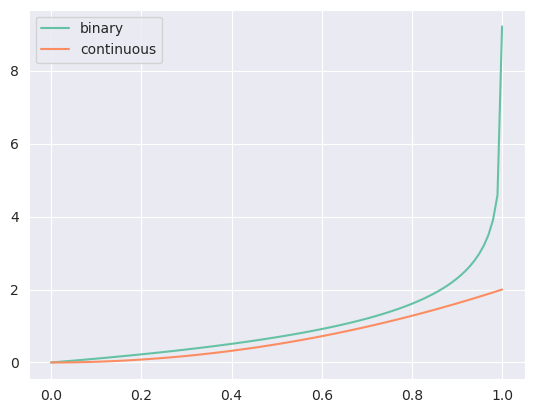

In [193]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,1,100), [i[0].item() for i in losses], label='binary')
plt.plot(np.linspace(0,1,100), [i[1].item() for i in losses], label='continuous')
plt.legend()
plt.show()


In [194]:
my3d_coord = model(data_tensor)

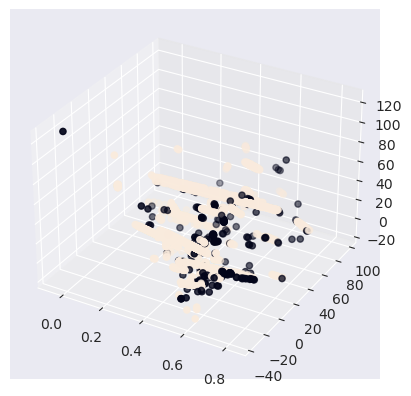

In [195]:
# plot 3 d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(my3d_coord[:,0].detach().numpy(), my3d_coord[:,1].detach().numpy(), my3d_coord[:,2].detach().numpy(), c=outlier_index)

In [196]:
import plotly.graph_objects as go
import numpy as np

# Example data
points = my3d_coord.detach().numpy()
labels = outlier_index
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers+text',
    text=labels,
    textposition='top center',
    marker=dict(size=5)
)])

# Adding labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Points with Labels'
)

# Show the plot
fig.show()


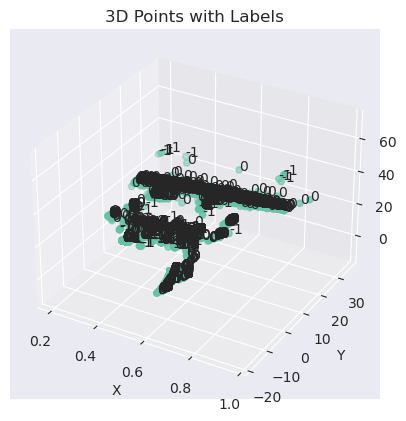

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

# Annotate each point with its label
for i, label in enumerate(labels):
    ax.text(points[i, 0], points[i, 1], points[i, 2], label)

# Adding labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Points with Labels')

# Show the plot
plt.show()

In [197]:
unique_labels = list(set(labels))
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # You can choose any colormap you like
color_dict = {label: color_map(i) for i, label in enumerate(unique_labels)}
colors = np.array([color_dict[label] for label in labels])
colors_hex = [f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, {c[3]})' for c in colors]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=colors_hex,  # Assign colors to each point
        opacity=0.8
    ),
    hovertext=labels,
    hoverinfo='text'
)])

# Adding labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Points with Hover Labels and Unique Colors'
)

# Show the plot
fig.show()

/tmp/ipykernel_36675/1047102969.py:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7200 samples in 0.025s...
[t-SNE] Computed neighbors for 7200 samples in 0.528s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7200
[t-SNE] Computed conditional probabilities for sample 2000 / 7200
[t-SNE] Computed conditional probabilities for sample 3000 / 7200
[t-SNE] Computed conditional probabilities for sample 4000 / 7200
[t-SNE] Computed conditional probabilities for sample 5000 / 7200
[t-SNE] Computed conditional probabilities for sample 6000 / 7200
[t-SNE] Computed conditional probabilities for sample 7000 / 7200
[t-SNE] Computed conditional probabilities for sample 7200 / 7200
[t-SNE] Mean sigma: 0.003135
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.279968
[t-SNE] KL divergence after 1000 iterations: 0.979912


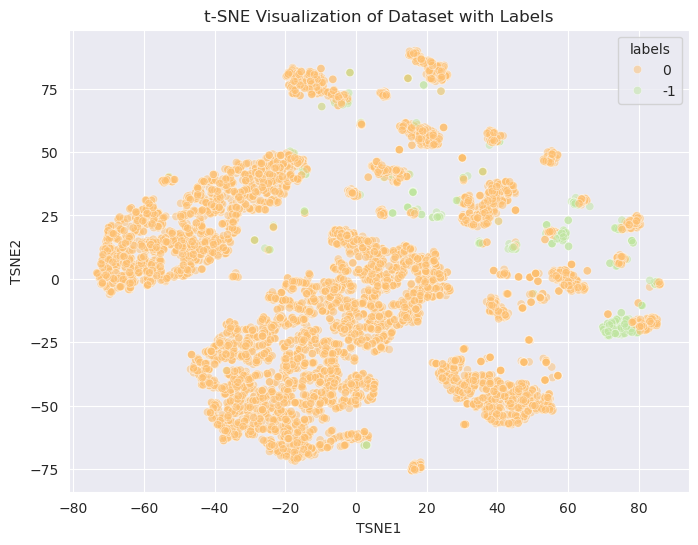

In [105]:
### 2d
utils.plot_TSNE(df, outlier_index, dist_matrix=gower.gower_matrix(df))

In [152]:
# Create a 2D scatter plot
my_2d_coord = model.encode(data_tensor).detach().numpy()

In [153]:
pd.DataFrame(outlier_index).replace({-1: 'Outlier', 0: 'Non-Outlier'}).value_counts()

Non-Outlier    6697
Outlier         503
Name: count, dtype: int64

<Axes: >

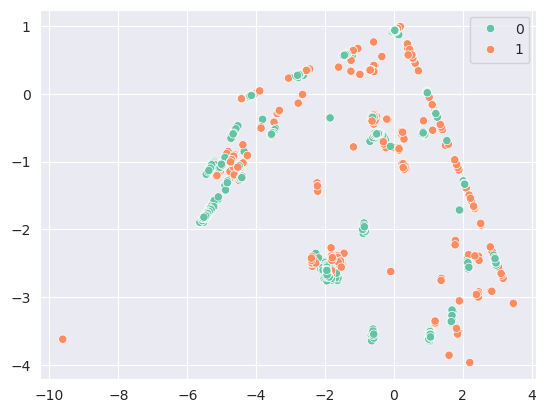

In [154]:
sns.scatterplot(x=my_2d_coord[:, 0], y=my_2d_coord[:, 1], hue= np.array(outlier_index) * -1)